In [ ]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import KBinsDiscretizer
# from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

# DataFrame Sampling Save

In [43]:
df = pd.read_csv('../Data/Cleaned_data_Inflation_Adjusted_.csv')
min_count = df['BoGender'].value_counts().min()
df = df.groupby('BoGender').sample(n=min_count, random_state=42)
df = df.reset_index(drop=True)
df.to_csv("Samples/BoGender.csv", index=False)

print("Saved Samples/BoGender.csv")

df = pd.read_csv('../Data/Cleaned_data_Inflation_Adjusted_.csv')
df = df[df['BoRace'] != 4]
min_count = df['BoRace'].value_counts().min()
df = df.groupby('BoRace').sample(n=min_count, random_state=42)
df = df.reset_index(drop=True)
df.to_csv("Samples/BoRace.csv", index=False)

print("Saved Samples/BoRace.csv")

df = pd.read_csv('../Data/Cleaned_data_Inflation_Adjusted_.csv')
df = df[~df['CoGender'].isin([4])]
min_count = df['CoGender'].value_counts().min()
df = df.groupby('CoGender').sample(n=min_count, random_state=42)
df = df.reset_index(drop=True)
df.to_csv("Samples/CoGender.csv", index=False)

print("Saved Samples/CoGender.csv")

df = pd.read_csv('../Data/Cleaned_data_Inflation_Adjusted_.csv')
df = df[~df['CoRace'].isin([4, 8])]
min_count = df['CoRace'].value_counts().min()
df = df.groupby('CoRace').sample(n=min_count, random_state=42)
df = df.reset_index(drop=True)
df.to_csv("Samples/CoRace.csv", index=False)

print("Saved Samples/CoRace.csv")

Saved Samples/BoGender.csv
Saved Samples/BoRace.csv
Saved Samples/CoGender.csv
Saved Samples/CoRace.csv


# Train/Test Split

In [ ]:
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = np.sum(cm) - np.sum(cm, axis=0) - np.sum(cm, axis=1) + np.diag(cm)
    fp = np.sum(cm, axis=0) - np.diag(cm)
    specificity_per_class = tn / (tn + fp)
    return np.mean(specificity_per_class)


def evaluate_models_on_split(df, target, models, labels, X, y, train_size=0.8, test_size=0.2):
    results_dir = f"{target}_SPLITS"
    os.makedirs(results_dir, exist_ok=True)

    train_percent = int(train_size * 100)
    test_percent = int(test_size * 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    print(f"\n{target} Training/Testing Split: {train_percent}%/{test_percent}%\n")

    results = {}
    conf_matrices = {}

    for name, model in models.items():
        start_time = time.time()

        if name == "XGBoost":
            le = LabelEncoder()
            y_train_enc = le.fit_transform(y_train)
            y_test_enc = le.transform(y_test)
            model.fit(X_train, y_train_enc)
            y_pred = le.inverse_transform(model.predict(X_test))
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='macro', zero_division=1)
        rec = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        spec = specificity_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        elapsed_time = time.time() - start_time

        results[name] = {
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1,
            "Specificity": spec,
            "Total Runtime (s)": elapsed_time,
        }
        conf_matrices[name] = cm

        print(f"Model: {name}\n Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}, Specificity: {spec:.4f}")
        print("Time taken: {:.2f} seconds\n".format(elapsed_time))

    results_df = pd.DataFrame(results).T
    results_file = os.path.join(results_dir, f"results_split_{train_percent}_{test_percent}.csv")
    results_df.to_csv(results_file)
    print(f"Results saved to {results_file}")

    for name, cm in conf_matrices.items():
        cm_file = os.path.join(results_dir, f"conf_matrix_{train_percent}_{test_percent}_{name.replace(' ', '_')}.csv")
        pd.DataFrame(cm).to_csv(cm_file, index=False)
        print(f"Confusion Matrix for {name} saved to {cm_file}")

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    for i, (name, cm) in enumerate(conf_matrices.items()):
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_norm = np.nan_to_num(cm_norm)

        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=axes[i],
                linewidths=0.5, linecolor='black', annot_kws={"size": 10},
                xticklabels=labels, yticklabels=labels)
        axes[i].set_title(f'{target} - Confusion Matrix - {name} ({train_percent}%/{test_percent}%)')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
        axes[i].set_yticklabels(axes[i].get_yticklabels(), rotation=45, va='center')

        plt.figure(figsize=(6, 6))
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
                linewidths=0.5, linecolor='black', annot_kws={"size": 10}, 
                xticklabels=labels, yticklabels=labels)
        plt.title(f'{target} - Confusion Matrix - {name} ({train_percent}%/{test_percent}%)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=45, va='center')
        save_path = os.path.join(results_dir, f"{target}_conf_matrix_{name.replace(' ', '_')}.png")
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()

    plt.tight_layout()
    plt.show()

In [ ]:
def cross_val_predict_xgb(model, X, y, cv):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_pred_all = np.zeros_like(y_encoded)

    for train_idx, test_idx in cv.split(X, y_encoded):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

        model.fit(X_train, y_train)
        y_pred_fold = model.predict(X_test)
        y_pred_all[test_idx] = y_pred_fold

    y_pred_final = le.inverse_transform(y_pred_all)
    return y_pred_final


def evaluate_models_on_CV(df, target, models, labels, X, y, num_folds = 10):  
    cv_results_dir = f"{target}_CV"
    os.makedirs(cv_results_dir, exist_ok=True)

    print(f"\n{target} Performing {num_folds}-fold cross-validation\n")
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    results = {}
    conf_matrices = {}

    for name, model in models.items():
        start_time = time.time()

        if name == "XGBoost":
            y_pred = cross_val_predict_xgb(model, X, y, cv=kf)
        else:
            y_pred = cross_val_predict(model, X, y, cv=kf)

        total_runtime = time.time() - start_time
        
        acc = accuracy_score(y, y_pred)
        prec = precision_score(y, y_pred, average='weighted', zero_division=1)
        rec = recall_score(y, y_pred, average='weighted')
        f1 = f1_score(y, y_pred, average='weighted')
        spec = specificity_score(y, y_pred)
        cm = confusion_matrix(y, y_pred)
        
        results[name] = {
            "Accuracy": acc, 
            "Precision": prec, 
            "Recall": rec, 
            "F1-Score": f1,
            "Specificity": spec, 
            "Total Runtime (s)": total_runtime, 
        }
        
        conf_matrices[name] = cm
        
        print(f"Model: {name}\n Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}, Specificity: {spec:.4f}")
        print("Time taken: {:.2f} seconds".format(total_runtime))

    results_df = pd.DataFrame(results).T
    results_file = f"{cv_results_dir}/results_cv_{num_folds}_folds.csv"
    results_df.to_csv(results_file, index=True)
    print(f"Results saved to {results_file}")

    for name, cm in conf_matrices.items():
        cm_file = f"{cv_results_dir}/conf_matrix_cv_{num_folds}_folds_{name.replace(' ', '_')}.csv"
        pd.DataFrame(cm).to_csv(cm_file, index=False)
        print(f"Confusion Matrix for {name} saved to {cm_file}")

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    for i, (name, cm) in enumerate(conf_matrices.items()):
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_norm = np.nan_to_num(cm_norm)

        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=axes[i], 
                    linewidths=0.5, linecolor='black', annot_kws={"size": 10}, 
                    xticklabels=labels, yticklabels=labels)
        axes[i].set_title(f'{target} - Confusion Matrix - {name} ({num_folds}-Folds CV)')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
        axes[i].set_yticklabels(axes[i].get_yticklabels(), rotation=45, va='center')

        plt.figure(figsize=(6, 6))
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
                    linewidths=0.5, linecolor='black', annot_kws={"size": 10},
                    xticklabels=labels, yticklabels=labels)
        plt.title(f'{target} - Confusion Matrix - {name} ({num_folds}-Folds CV)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=45, va='center')
        save_path = os.path.join(cv_results_dir, f"{target}_conf_matrix_{name.replace(' ', '_')}.png")
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()

    plt.tight_layout()
    plt.show()

In [ ]:
models = {
    "ZeroR": DummyClassifier(strategy="most_frequent"),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(verbosity=0, use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(verbose=-1, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
}


BoGender Training/Testing Split: 80%/20%

Model: ZeroR
 Accuracy: 0.3306, Precision: 0.7769, Recall: 0.3333, F1-Score: 0.1656, Specificity: 0.6667
Time taken: 0.01 seconds

Model: Random Forest
 Accuracy: 0.7367, Precision: 0.7407, Recall: 0.7363, F1-Score: 0.7382, Specificity: 0.8685
Time taken: 13.04 seconds

Model: Gradient Boosting
 Accuracy: 0.7369, Precision: 0.7409, Recall: 0.7365, F1-Score: 0.7384, Specificity: 0.8686
Time taken: 44.93 seconds



c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:15:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model: XGBoost
 Accuracy: 0.7530, Precision: 0.7563, Recall: 0.7526, F1-Score: 0.7540, Specificity: 0.8766
Time taken: 0.42 seconds

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3456
[LightGBM] [Info] Number of data points in the train set: 60880, number of used features: 28
[LightGBM] [Info] Start training from score -1.096561
[LightGBM] [Info] Start training from score -1.099368
[LightGBM] [Info] Start training from score -1.099911
Model: LightGBM
 Accuracy: 0.7552, Precision: 0.7585, Recall: 0.7548, F1-Score: 0.7562, Specificity: 0.8777
Time taken: 0.38 seconds

Model: CatBoost
 Accuracy: 0.7514, Precision: 0.7551, Recall: 0.7510, F1-Score: 0.7526, Specificity: 0.8758
Time taken: 5.06 seconds

Results saved to BoGender_SPLITS\results_split_80_20.csv
Confusion M

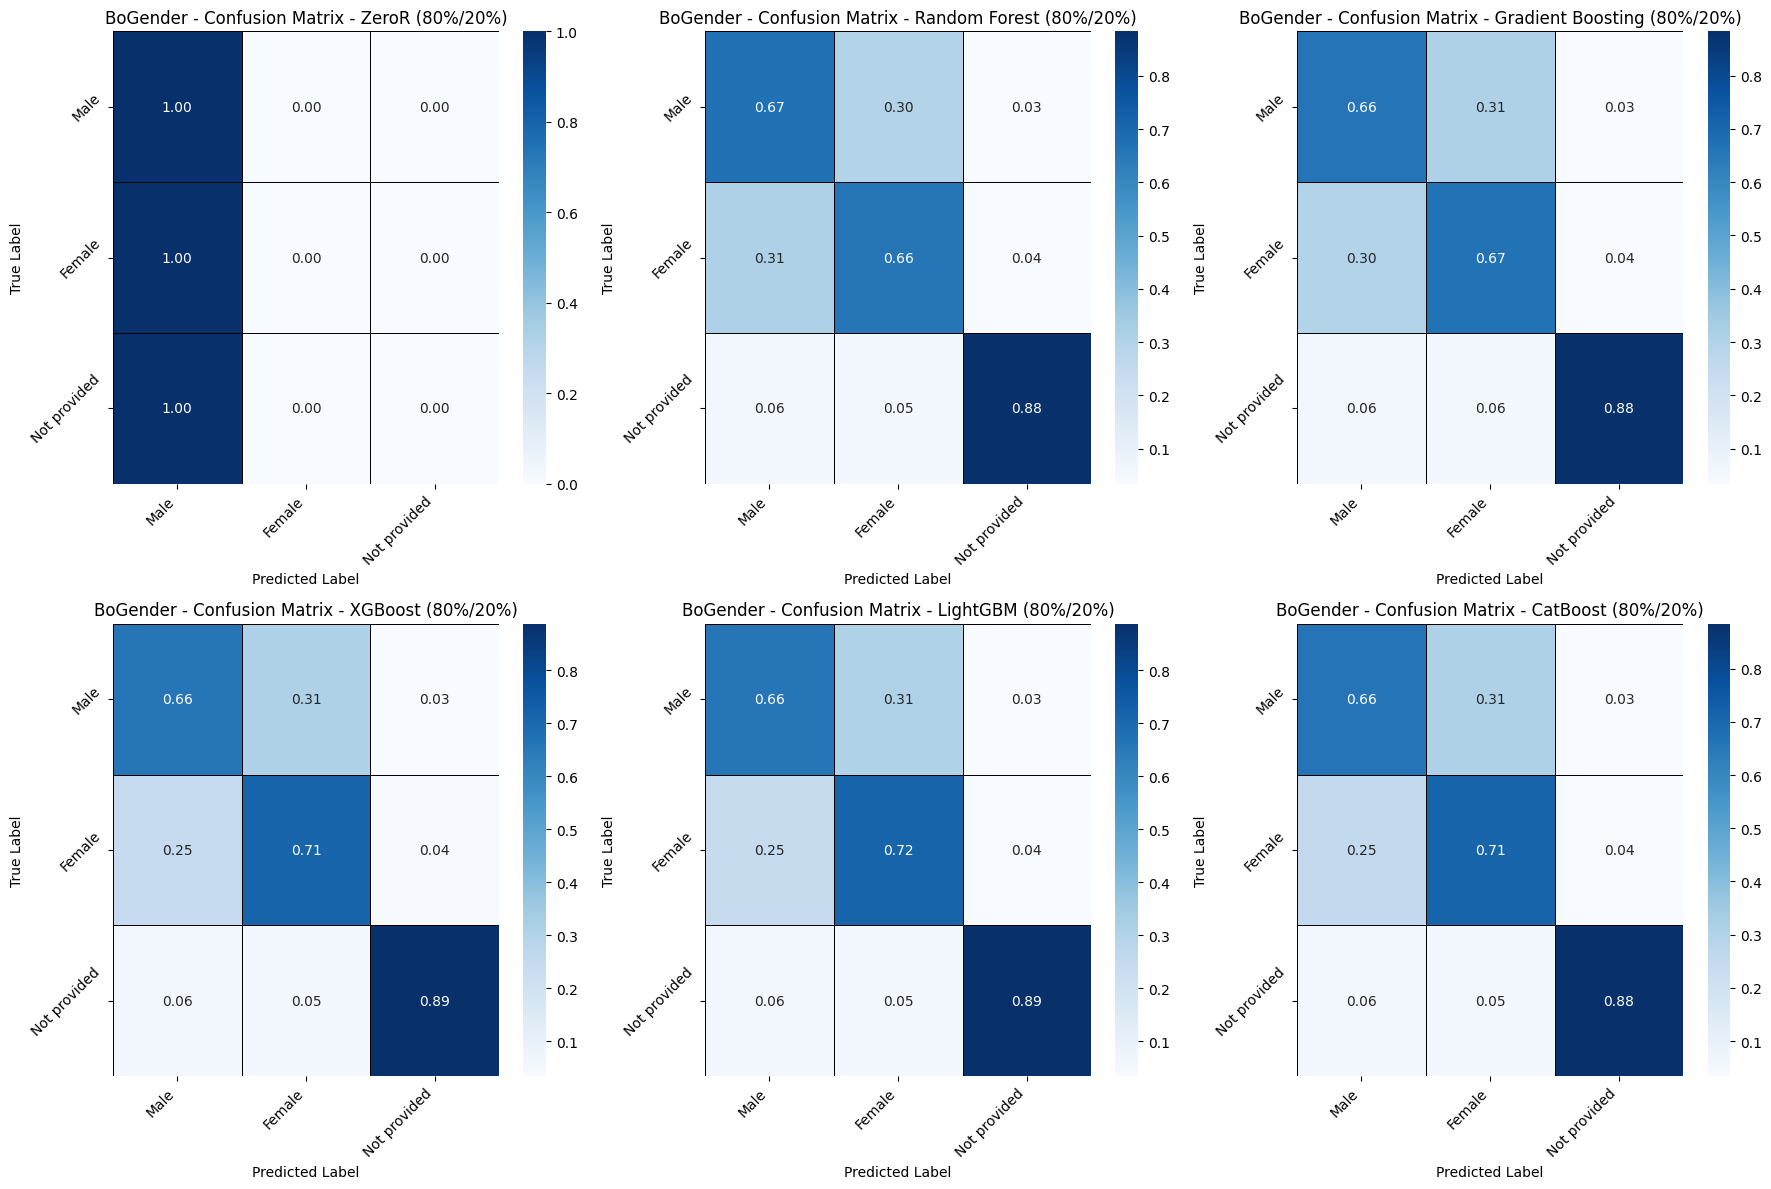


BoGender Performing 10-fold cross-validation

Model: ZeroR
 Accuracy: 0.3333, Precision: 0.3333, Recall: 0.3333, F1-Score: 0.3317, Specificity: 0.6666
Time taken: 0.07 seconds
Model: Random Forest
 Accuracy: 0.7332, Precision: 0.7384, Recall: 0.7332, F1-Score: 0.7354, Specificity: 0.8666
Time taken: 145.57 seconds
Model: Gradient Boosting
 Accuracy: 0.7384, Precision: 0.7434, Recall: 0.7384, F1-Score: 0.7406, Specificity: 0.8692
Time taken: 522.00 seconds


c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:27:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:27:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:27:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:27:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "

Model: XGBoost
 Accuracy: 0.7532, Precision: 0.7573, Recall: 0.7532, F1-Score: 0.7547, Specificity: 0.8766
Time taken: 4.62 seconds
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3463
[LightGBM] [Info] Number of data points in the train set: 68490, number of used features: 28
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3460
[LightGBM] [Info] Number of data points in the train set: 684

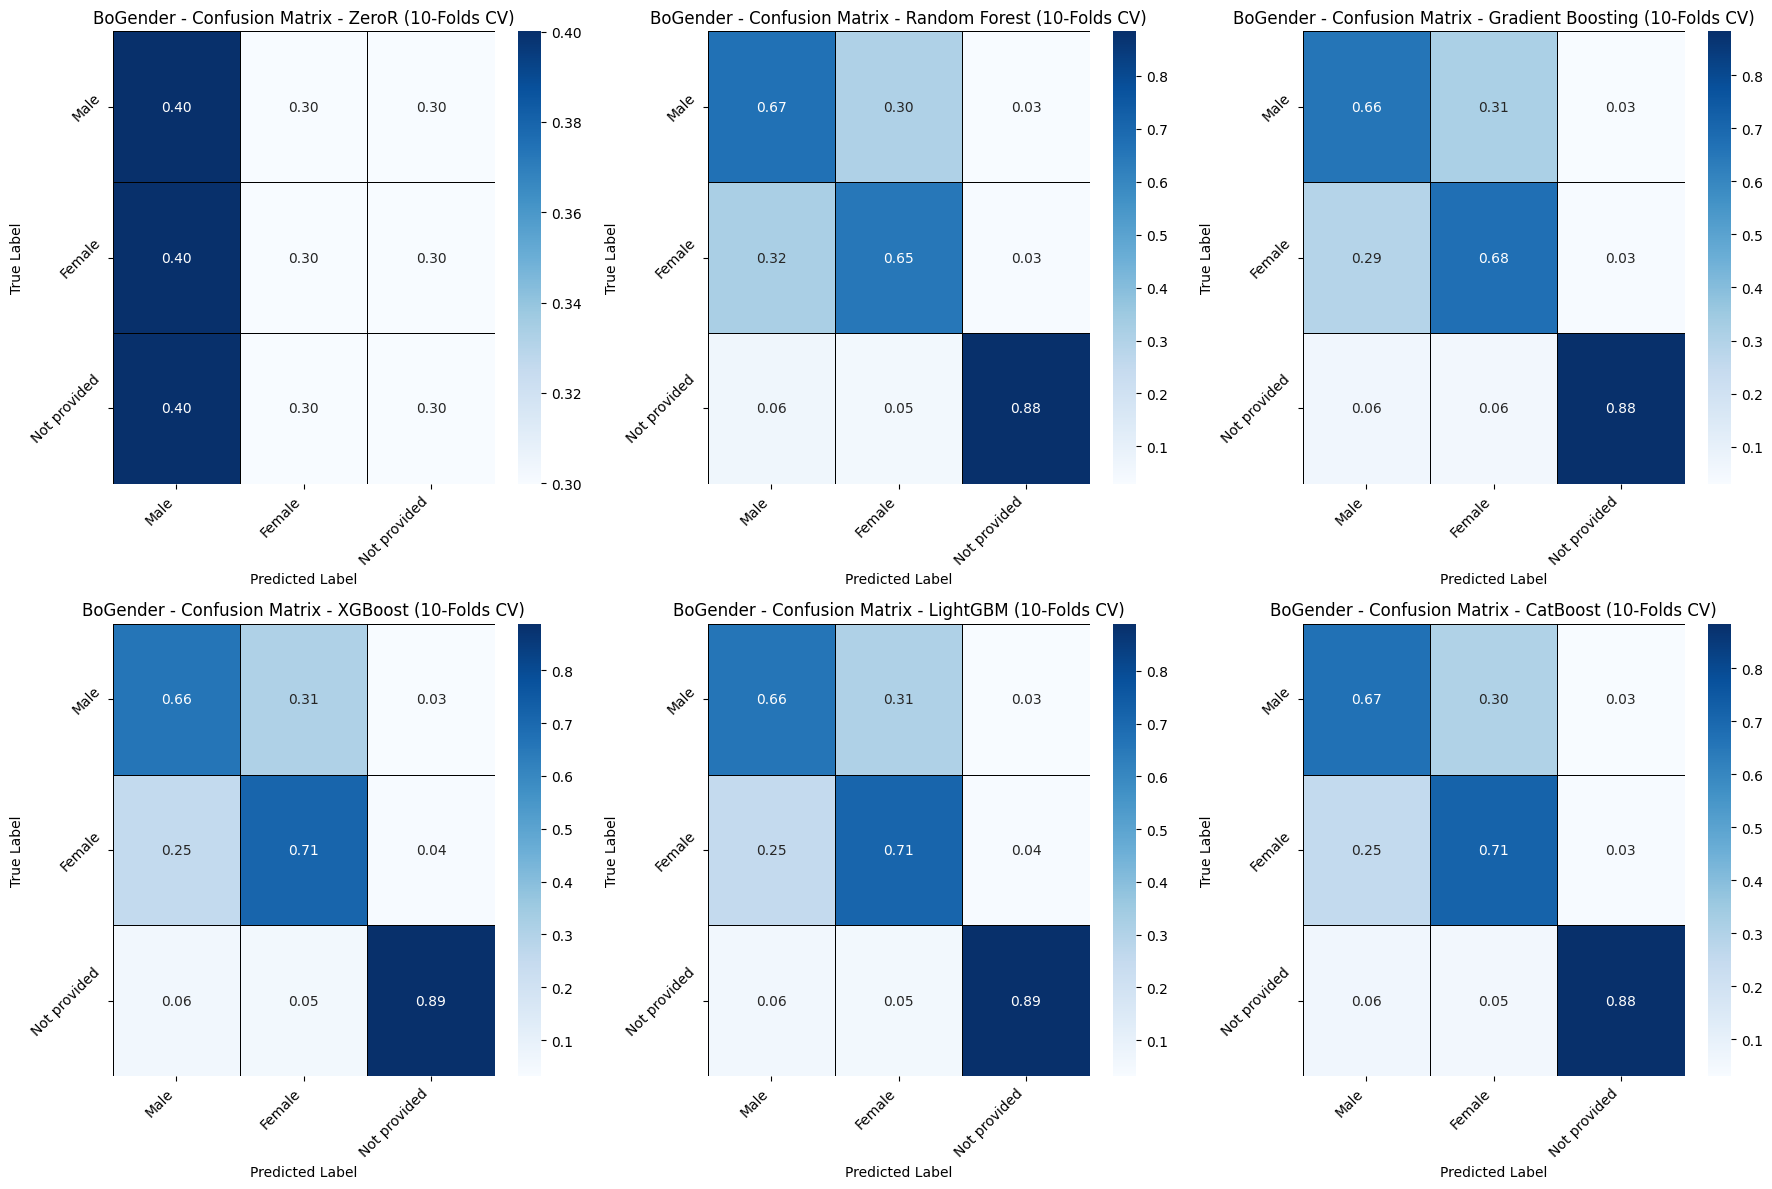

In [37]:
df = pd.read_csv("Samples/BoGender.csv")
X = df.drop(columns=["BoGender", "CoGender"])
y = df["BoGender"]
labels = ["Male", "Female", "Not provided"]

evaluate_models_on_split(df, "BoGender", models, labels, X, y)
evaluate_models_on_CV(df, "BoGender", models, labels, X, y)


BoRace Training/Testing Split: 80%/20%

Model: ZeroR
 Accuracy: 0.3329, Precision: 0.8666, Recall: 0.2000, F1-Score: 0.0999, Specificity: 0.8000
Time taken: 0.01 seconds

Model: Random Forest
 Accuracy: 0.6095, Precision: 0.6025, Recall: 0.5963, F1-Score: 0.5971, Specificity: 0.9007
Time taken: 3.47 seconds

Model: Gradient Boosting
 Accuracy: 0.6064, Precision: 0.5994, Recall: 0.5976, F1-Score: 0.5959, Specificity: 0.9004
Time taken: 23.59 seconds



c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:28:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model: XGBoost
 Accuracy: 0.6181, Precision: 0.6090, Recall: 0.6033, F1-Score: 0.6043, Specificity: 0.9028
Time taken: 0.44 seconds

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3287
[LightGBM] [Info] Number of data points in the train set: 18105, number of used features: 28
[LightGBM] [Info] Start training from score -1.792920
[LightGBM] [Info] Start training from score -1.799578
[LightGBM] [Info] Start training from score -1.787626
[LightGBM] [Info] Start training from score -1.787626
[LightGBM] [Info] Start training from score -1.098281
Model: LightGBM
 Accuracy: 0.6176, Precision: 0.6115, Recall: 0.6056, F1-Score: 0.6058, Specificity: 0.9030
Time taken: 0.39 seconds

Model: CatBoost
 Accuracy: 0.6181, Precision: 0.6085, Recall: 0.6061, F1-Score: 0.6057, Specif

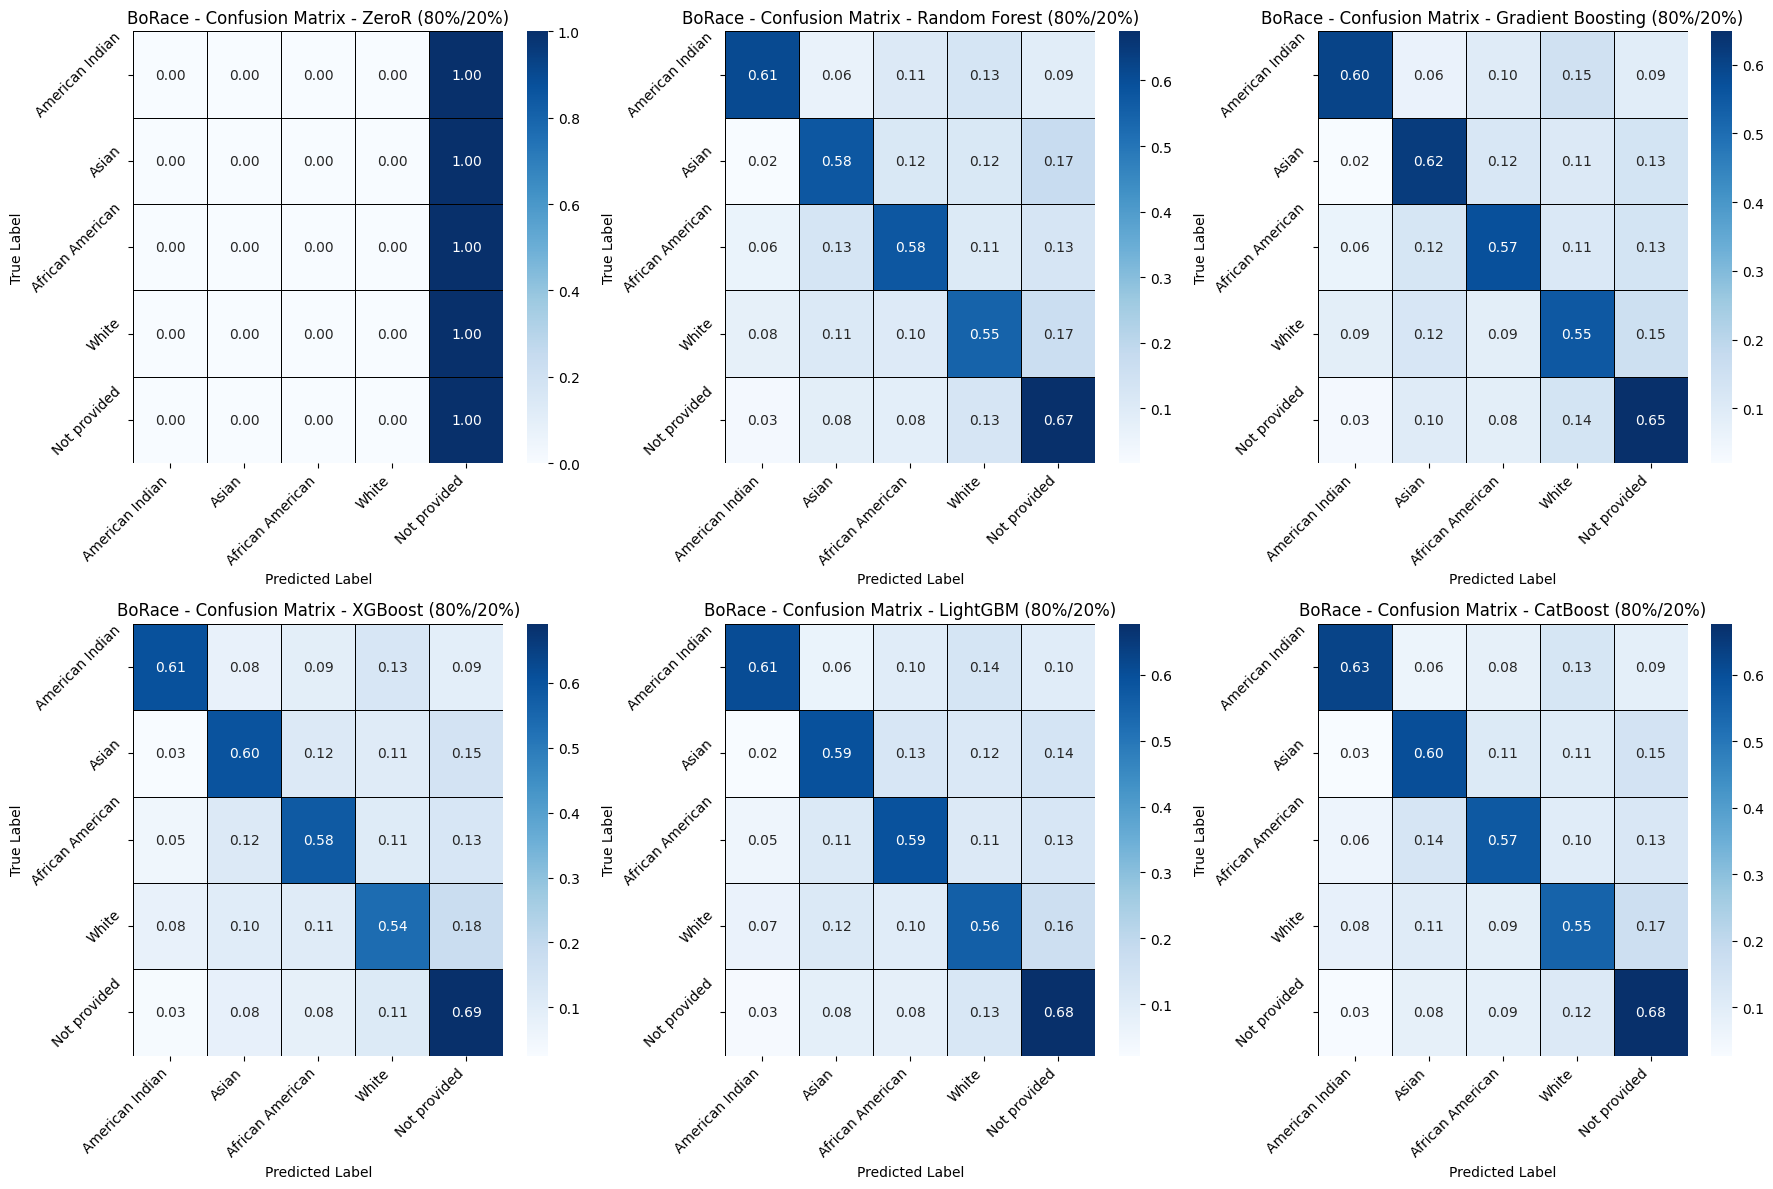


BoRace Performing 10-fold cross-validation

Model: ZeroR
 Accuracy: 0.3333, Precision: 0.7778, Recall: 0.3333, F1-Score: 0.1667, Specificity: 0.8000
Time taken: 0.03 seconds
Model: Random Forest
 Accuracy: 0.5900, Precision: 0.6047, Recall: 0.5900, F1-Score: 0.5928, Specificity: 0.8962
Time taken: 40.44 seconds
Model: Gradient Boosting
 Accuracy: 0.5877, Precision: 0.6058, Recall: 0.5877, F1-Score: 0.5917, Specificity: 0.8963
Time taken: 263.70 seconds


c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:33:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:33:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:33:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:34:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "

Model: XGBoost
 Accuracy: 0.5675, Precision: 0.5793, Recall: 0.5675, F1-Score: 0.5657, Specificity: 0.8906
Time taken: 4.48 seconds
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3285
[LightGBM] [Info] Number of data points in the train set: 20368, number of used features: 28
[LightGBM] [Info] Start training from score -1.791956
[LightGBM] [Info] Start training from score -1.791661
[LightGBM] [Info] Start training from score -1.791661
[LightGBM] [Info] Start training from score -1.791661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_col_wise=true` to remove t

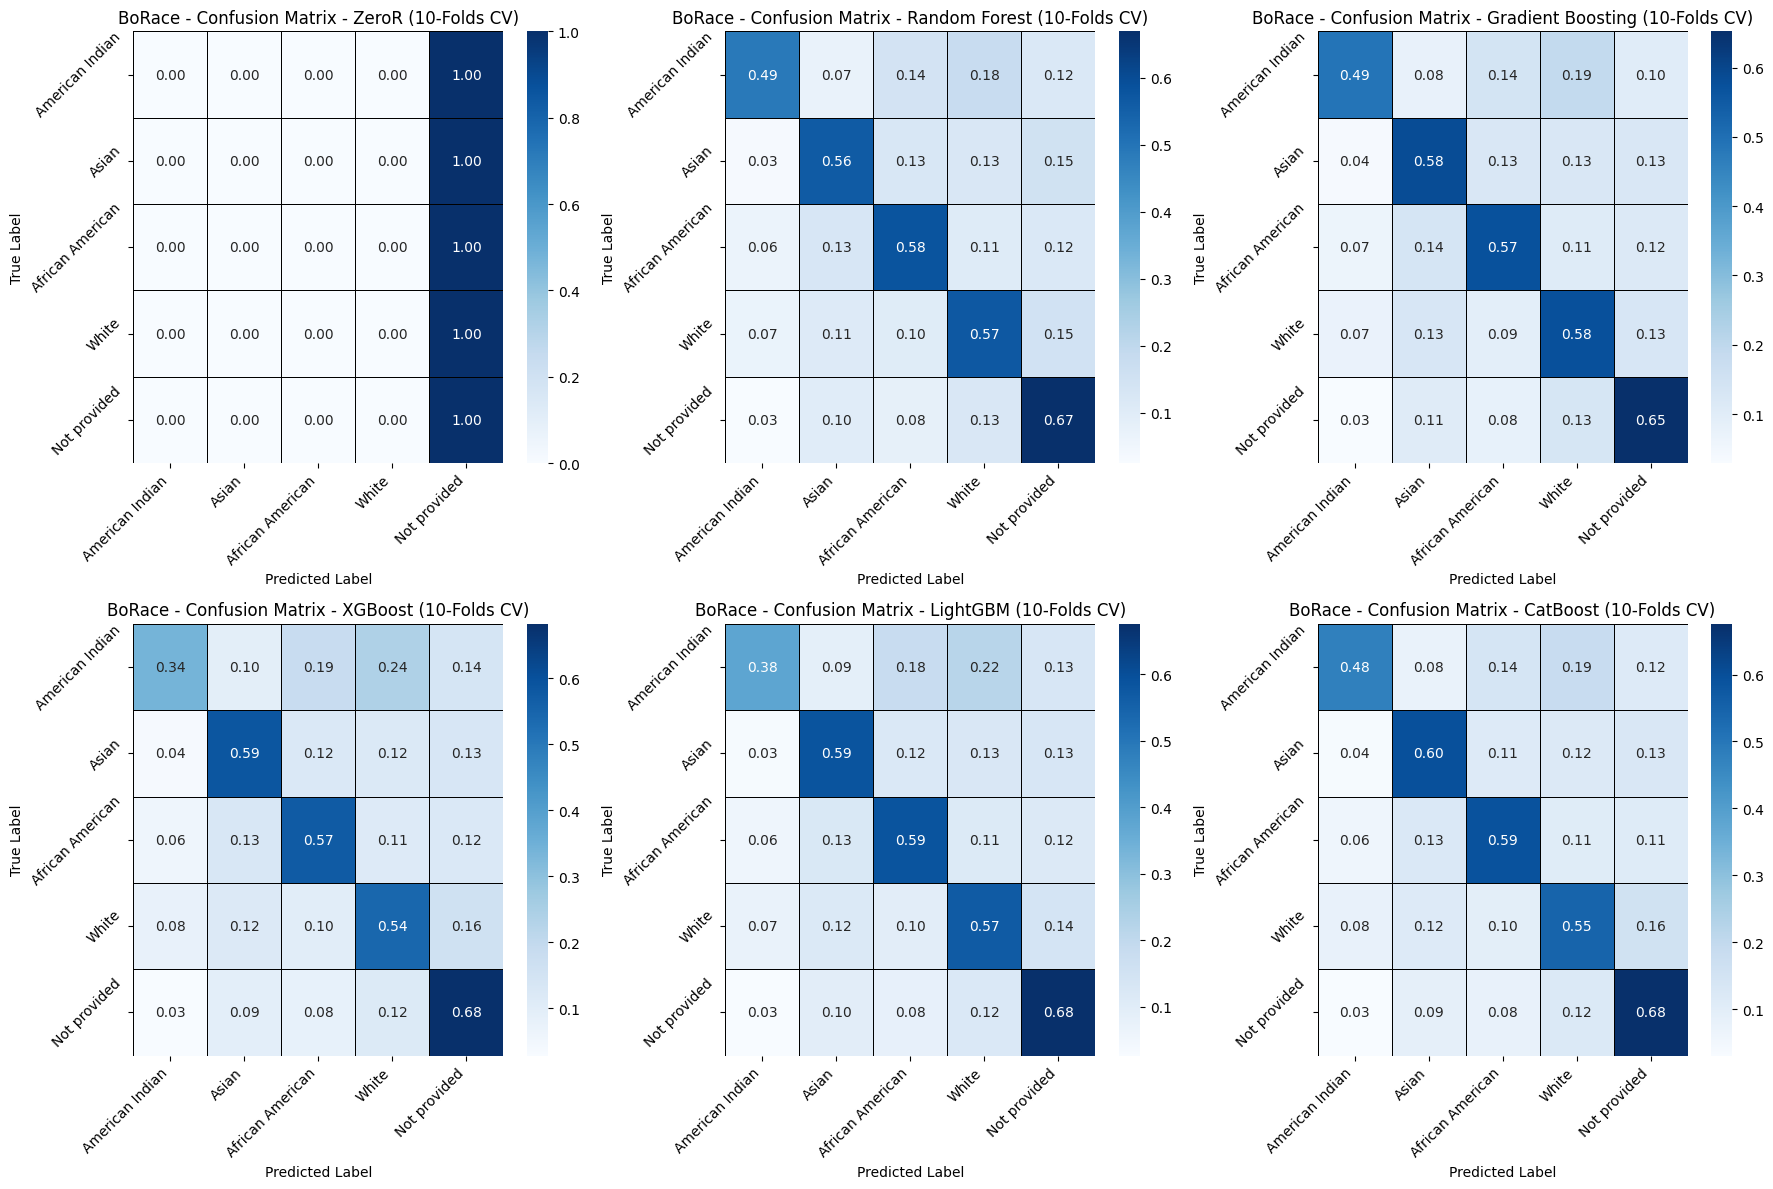

In [38]:
df = pd.read_csv("Samples/BoRace.csv")
X = df.drop(columns=["BoRace", "CoRace"])
y = df["BoRace"]
labels = ["American Indian", "Asian", "African American", "White", "Not provided"]

evaluate_models_on_split(df, "BoRace", models, labels, X, y)
evaluate_models_on_CV(df, "BoRace", models, labels, X, y)


CoGender Training/Testing Split: 80%/20%

Model: ZeroR
 Accuracy: 0.3330, Precision: 0.7777, Recall: 0.3333, F1-Score: 0.1666, Specificity: 0.6667
Time taken: 0.01 seconds

Model: Random Forest
 Accuracy: 0.7263, Precision: 0.7270, Recall: 0.7263, F1-Score: 0.7267, Specificity: 0.8632
Time taken: 7.47 seconds

Model: Gradient Boosting
 Accuracy: 0.7590, Precision: 0.7601, Recall: 0.7590, F1-Score: 0.7591, Specificity: 0.8795
Time taken: 27.82 seconds



c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:35:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model: XGBoost
 Accuracy: 0.7603, Precision: 0.7611, Recall: 0.7603, F1-Score: 0.7604, Specificity: 0.8802
Time taken: 0.41 seconds

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3361
[LightGBM] [Info] Number of data points in the train set: 36919, number of used features: 28
[LightGBM] [Info] Start training from score -1.098396
[LightGBM] [Info] Start training from score -1.098802
[LightGBM] [Info] Start training from score -1.098639
Model: LightGBM
 Accuracy: 0.7653, Precision: 0.7663, Recall: 0.7653, F1-Score: 0.7652, Specificity: 0.8827
Time taken: 0.29 seconds

Model: CatBoost
 Accuracy: 0.7637, Precision: 0.7647, Recall: 0.7637, F1-Score: 0.7637, Specificity: 0.8819
Time taken: 4.24 seconds

Results saved to CoGender_SPLITS\results_split_80_20.csv
Confusion M

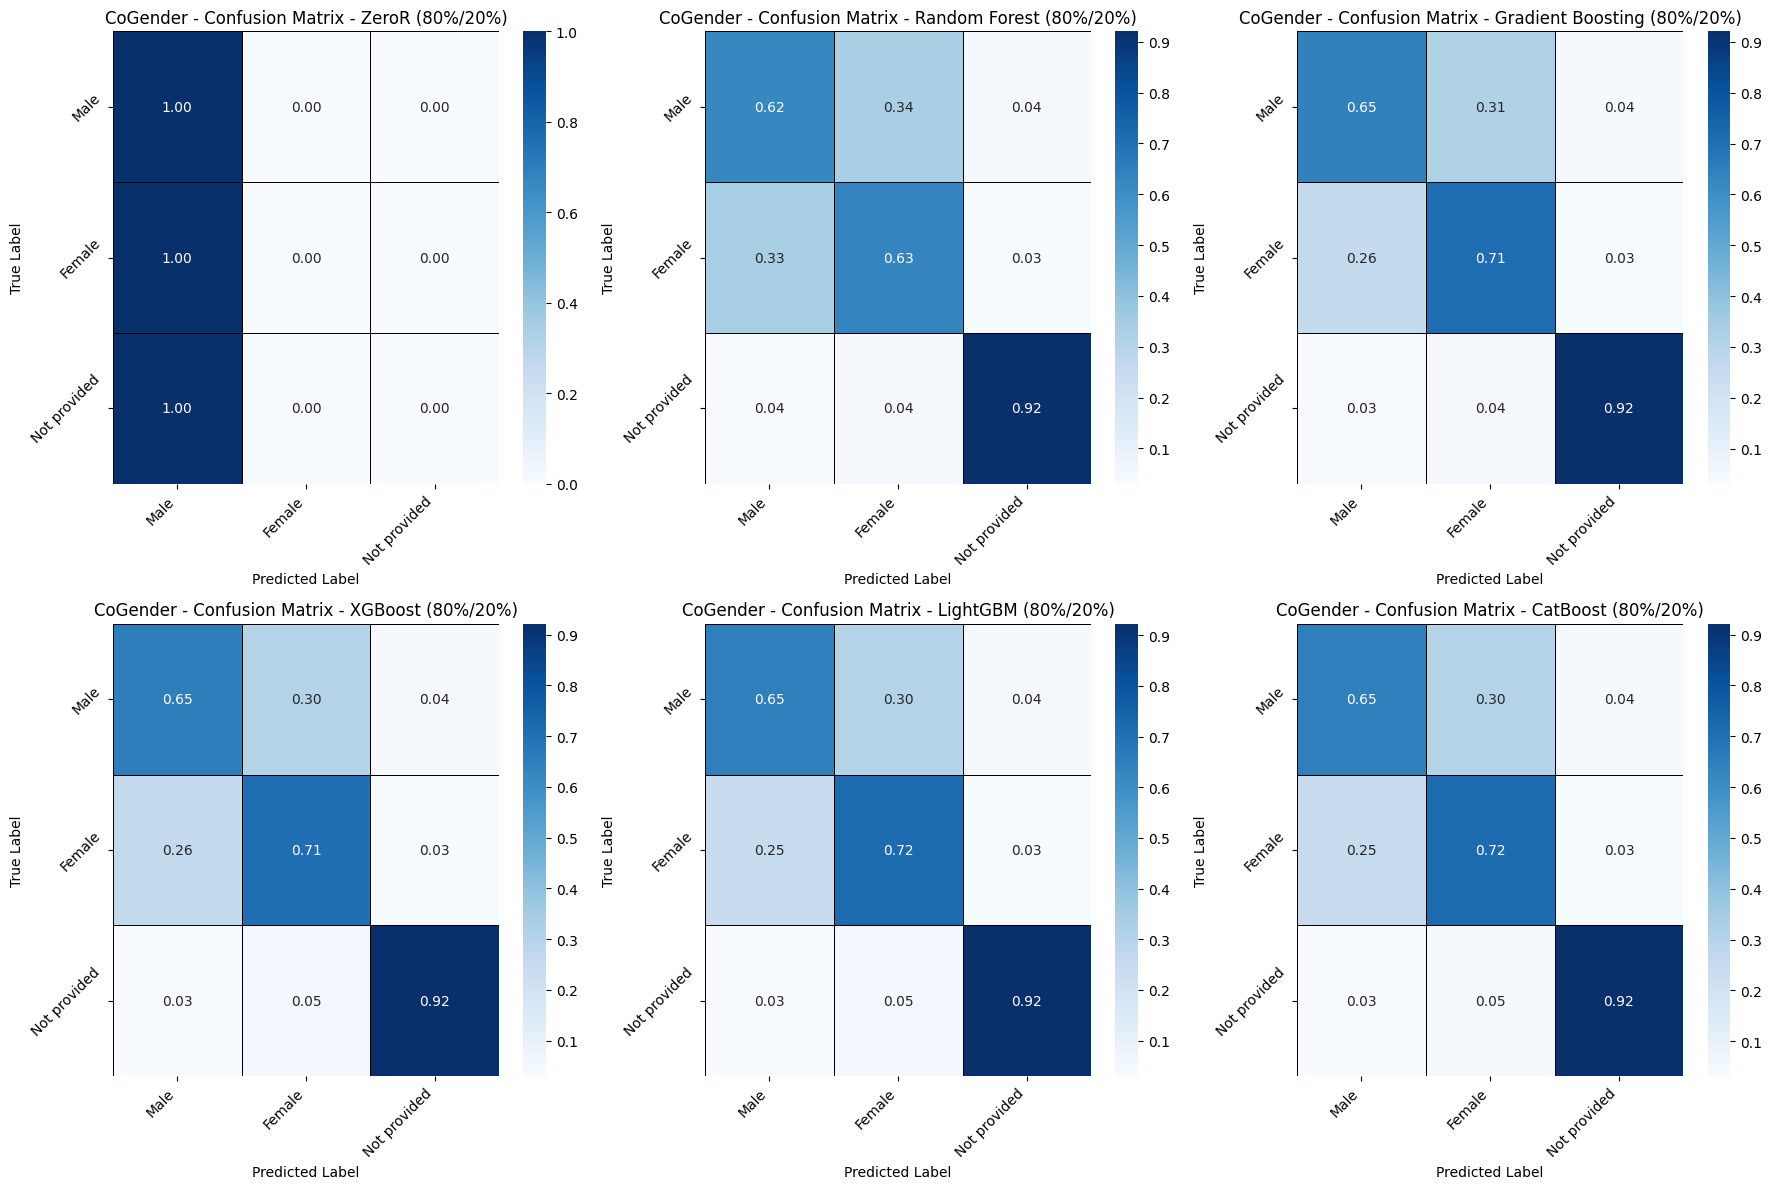


CoGender Performing 10-fold cross-validation

Model: ZeroR
 Accuracy: 0.3333, Precision: 0.5555, Recall: 0.3333, F1-Score: 0.2558, Specificity: 0.6666
Time taken: 0.05 seconds
Model: Random Forest
 Accuracy: 0.7279, Precision: 0.7291, Recall: 0.7279, F1-Score: 0.7285, Specificity: 0.8640
Time taken: 83.55 seconds
Model: Gradient Boosting
 Accuracy: 0.7636, Precision: 0.7649, Recall: 0.7636, F1-Score: 0.7639, Specificity: 0.8818
Time taken: 330.27 seconds


c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:42:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:42:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:42:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:42:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "

Model: XGBoost
 Accuracy: 0.7658, Precision: 0.7667, Recall: 0.7658, F1-Score: 0.7659, Specificity: 0.8829
Time taken: 3.71 seconds
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 41534, number of used features: 28
[LightGBM] [Info] Start training from score -1.098660
[LightGBM] [Info] Start training from score -1.098588
[LightGBM] [Info] Start training from score -1.098588
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3377
[LightGBM] [Info] Number of data points in the train set: 415

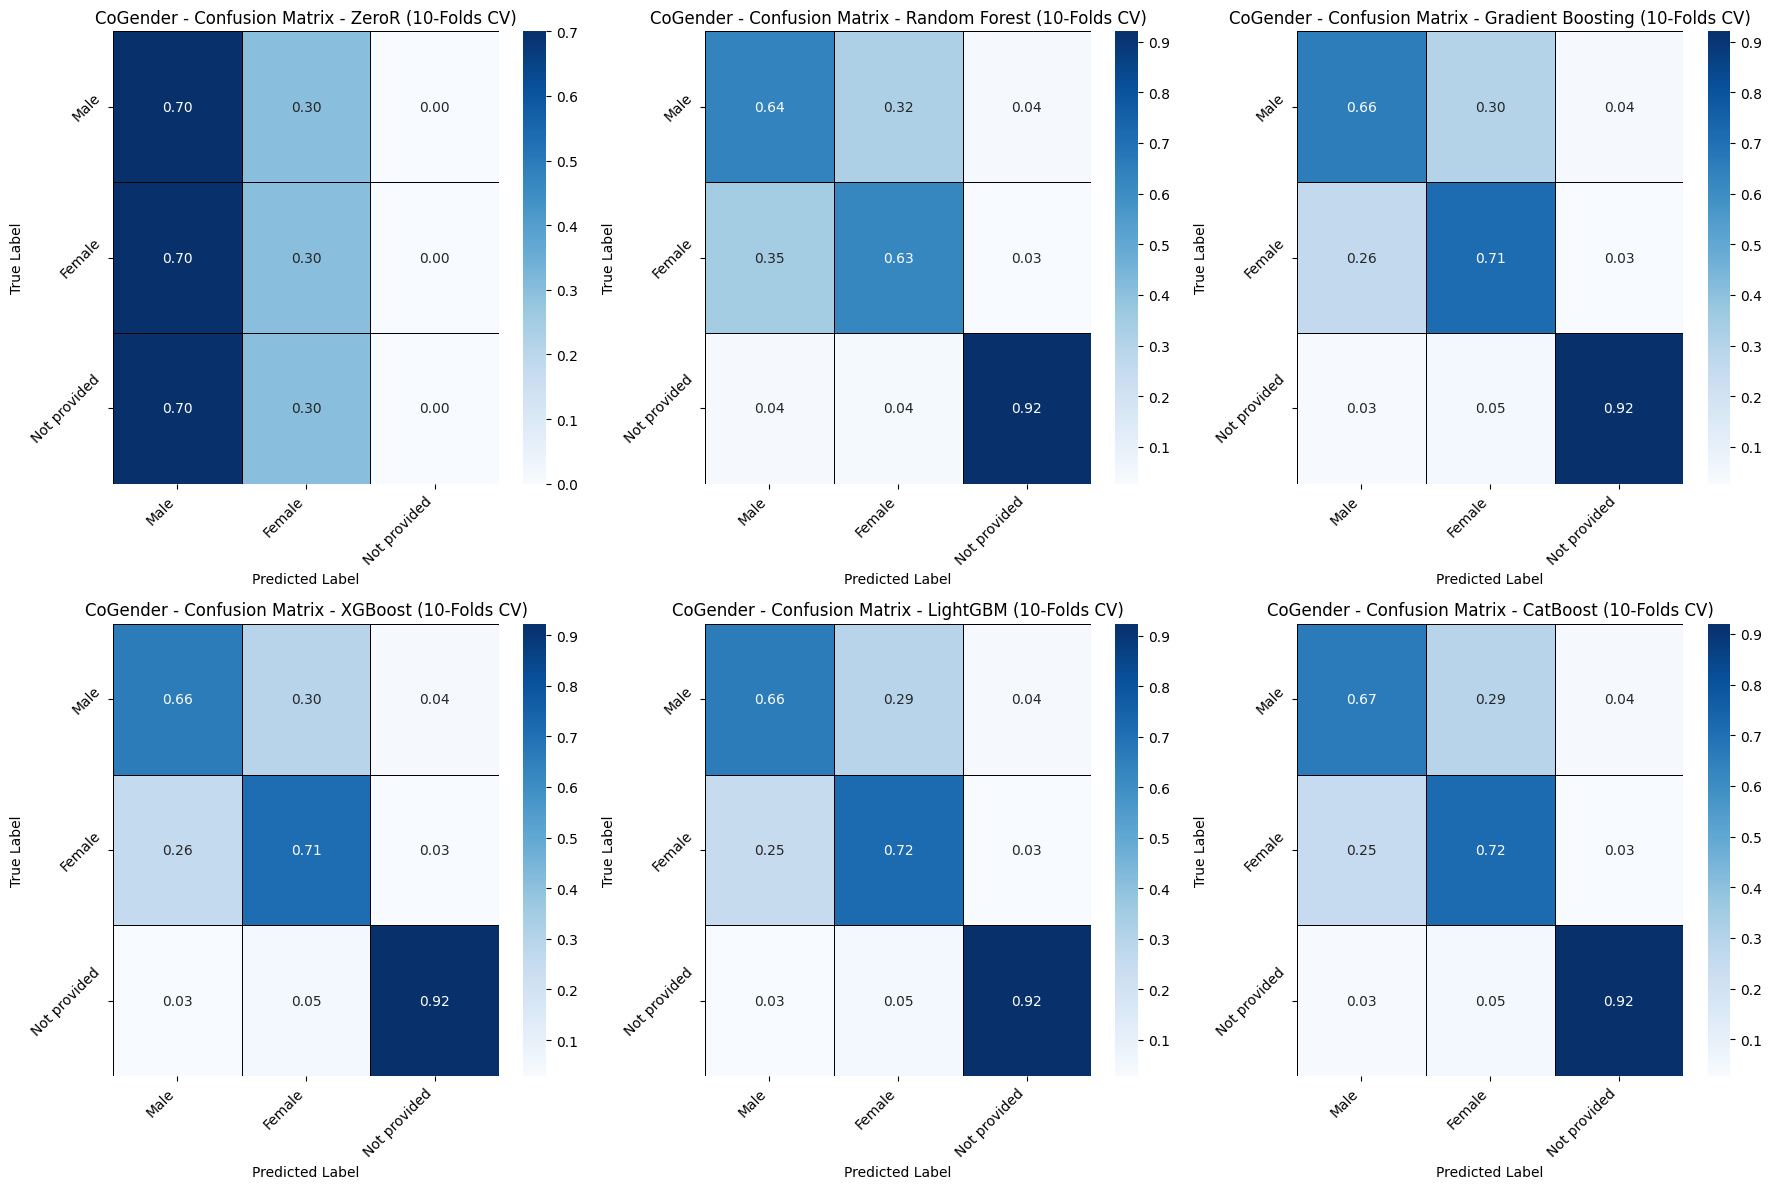

In [39]:
df = pd.read_csv("Samples/CoGender.csv")
X = df.drop(columns=["BoGender", "CoGender"])
y = df["CoGender"]
labels = ["Male", "Female", "Not provided"]

evaluate_models_on_split(df, "CoGender", models, labels, X, y)
evaluate_models_on_CV(df, "CoGender", models, labels, X, y)


CoRace Training/Testing Split: 80%/20%

Model: ZeroR
 Accuracy: 0.1864, Precision: 0.8373, Recall: 0.2000, F1-Score: 0.0628, Specificity: 0.8000
Time taken: 0.01 seconds

Model: Random Forest
 Accuracy: 0.5746, Precision: 0.6085, Recall: 0.5740, F1-Score: 0.5793, Specificity: 0.8944
Time taken: 1.08 seconds

Model: Gradient Boosting
 Accuracy: 0.5826, Precision: 0.6173, Recall: 0.5829, F1-Score: 0.5871, Specificity: 0.8965
Time taken: 7.56 seconds



c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:07:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model: XGBoost
 Accuracy: 0.5658, Precision: 0.5791, Recall: 0.5644, F1-Score: 0.5674, Specificity: 0.8920
Time taken: 0.38 seconds

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3192
[LightGBM] [Info] Number of data points in the train set: 5472, number of used features: 28
[LightGBM] [Info] Start training from score -1.610718
[LightGBM] [Info] Start training from score -1.592585
[LightGBM] [Info] Start training from score -1.606154
[LightGBM] [Info] Start training from score -1.600704
[LightGBM] [Info] Start training from score -1.637609
Model: LightGBM
 Accuracy: 0.5826, Precision: 0.5995, Recall: 0.5821, F1-Score: 0.5848, Specificity: 0.8962
Time taken: 0.26 seconds

Model: CatBoost
 Accuracy: 0.5811, Precision: 0.5996, Recall: 0.5806, F1-Score: 0.5834, Specifi

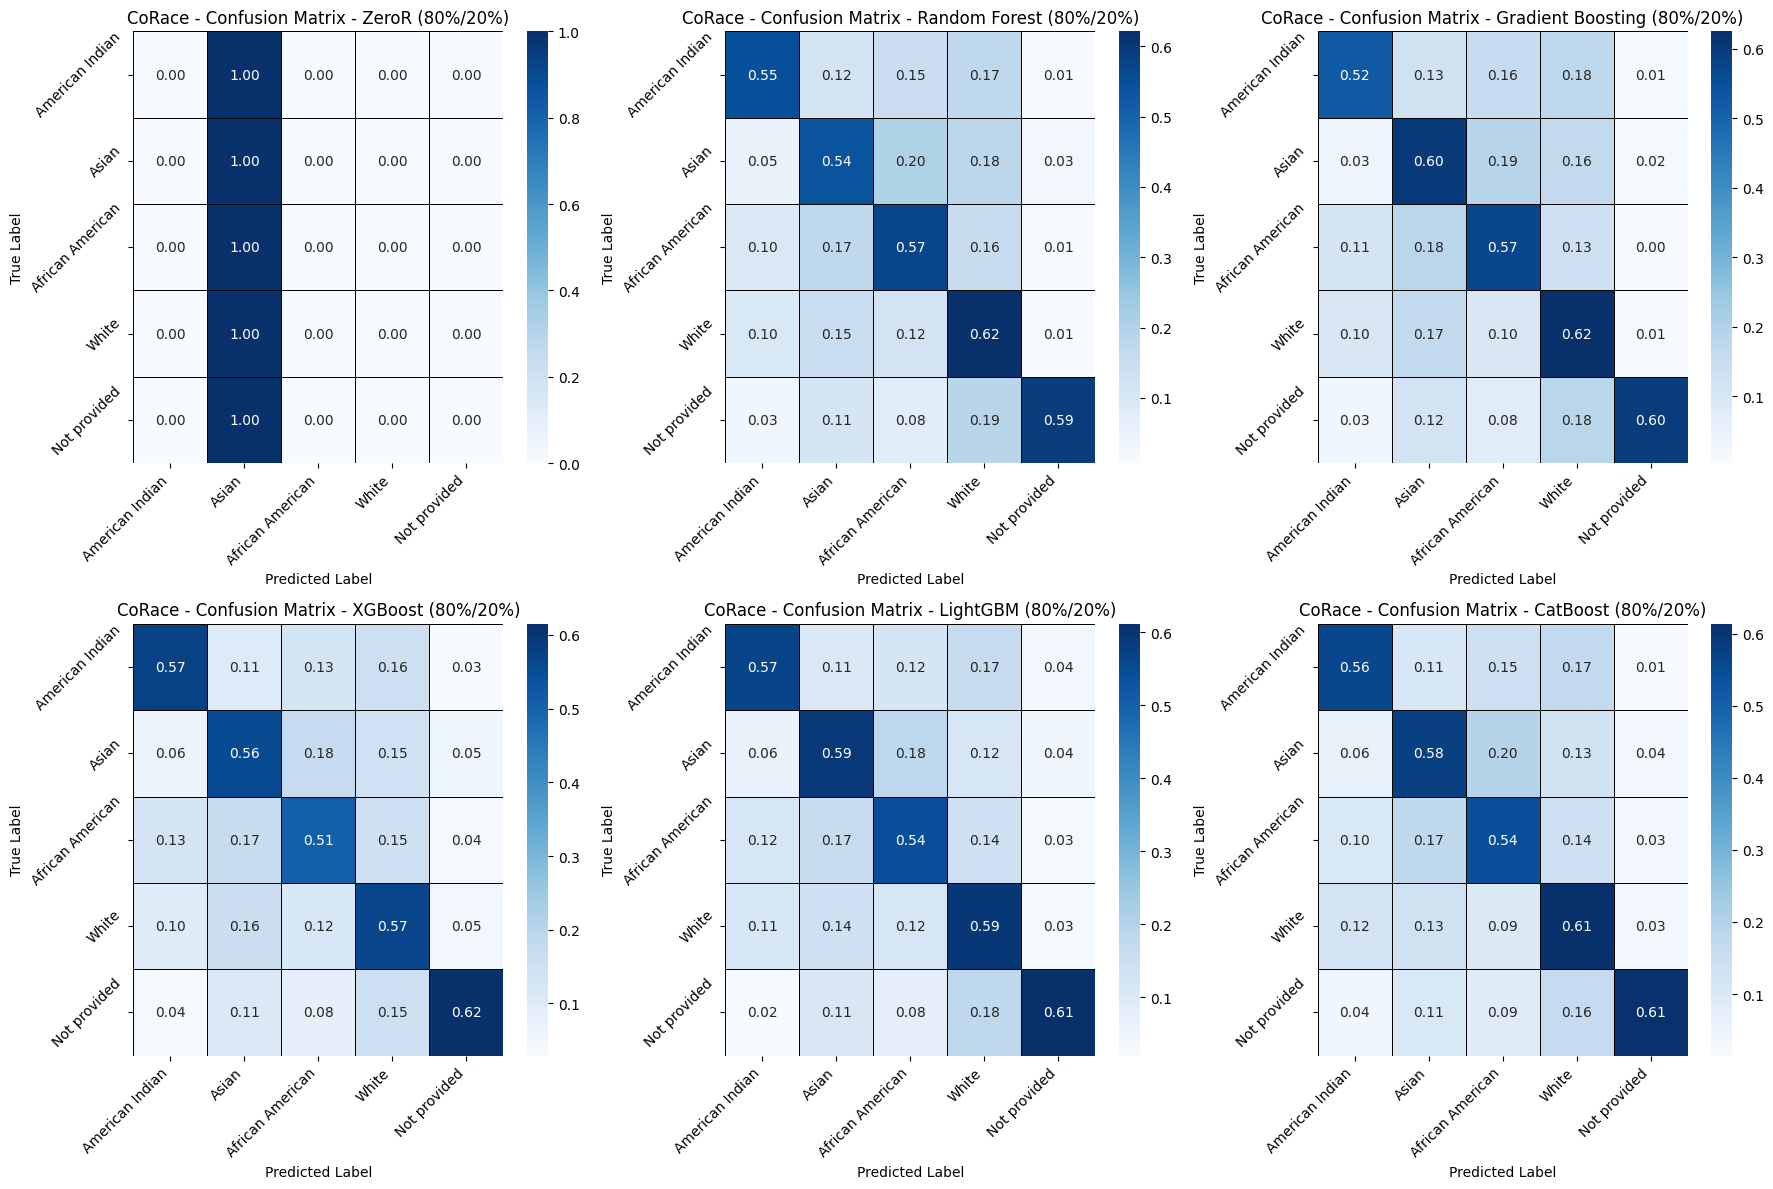


CoRace Performing 10-fold cross-validation

Model: ZeroR
 Accuracy: 0.1988, Precision: 0.1988, Recall: 0.1988, F1-Score: 0.1988, Specificity: 0.7997
Time taken: 0.01 seconds
Model: Random Forest
 Accuracy: 0.5683, Precision: 0.6050, Recall: 0.5683, F1-Score: 0.5749, Specificity: 0.8921
Time taken: 11.50 seconds
Model: Gradient Boosting
 Accuracy: 0.5763, Precision: 0.6145, Recall: 0.5763, F1-Score: 0.5830, Specificity: 0.8941
Time taken: 84.12 seconds


c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:09:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:09:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:09:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:09:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "

Model: XGBoost
 Accuracy: 0.5632, Precision: 0.5816, Recall: 0.5632, F1-Score: 0.5675, Specificity: 0.8908
Time taken: 3.55 seconds
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3200
[LightGBM] [Info] Number of data points in the train set: 6156, number of used features: 28
[LightGBM] [Info] Start training from score -1.609600
[LightGBM] [Info] Start training from score -1.609600
[LightGBM] [Info] Start training from score -1.609600
[LightGBM] [Info] Start training from score -1.609600
[LightGBM] [Info] Start training from score -1.608788
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove th

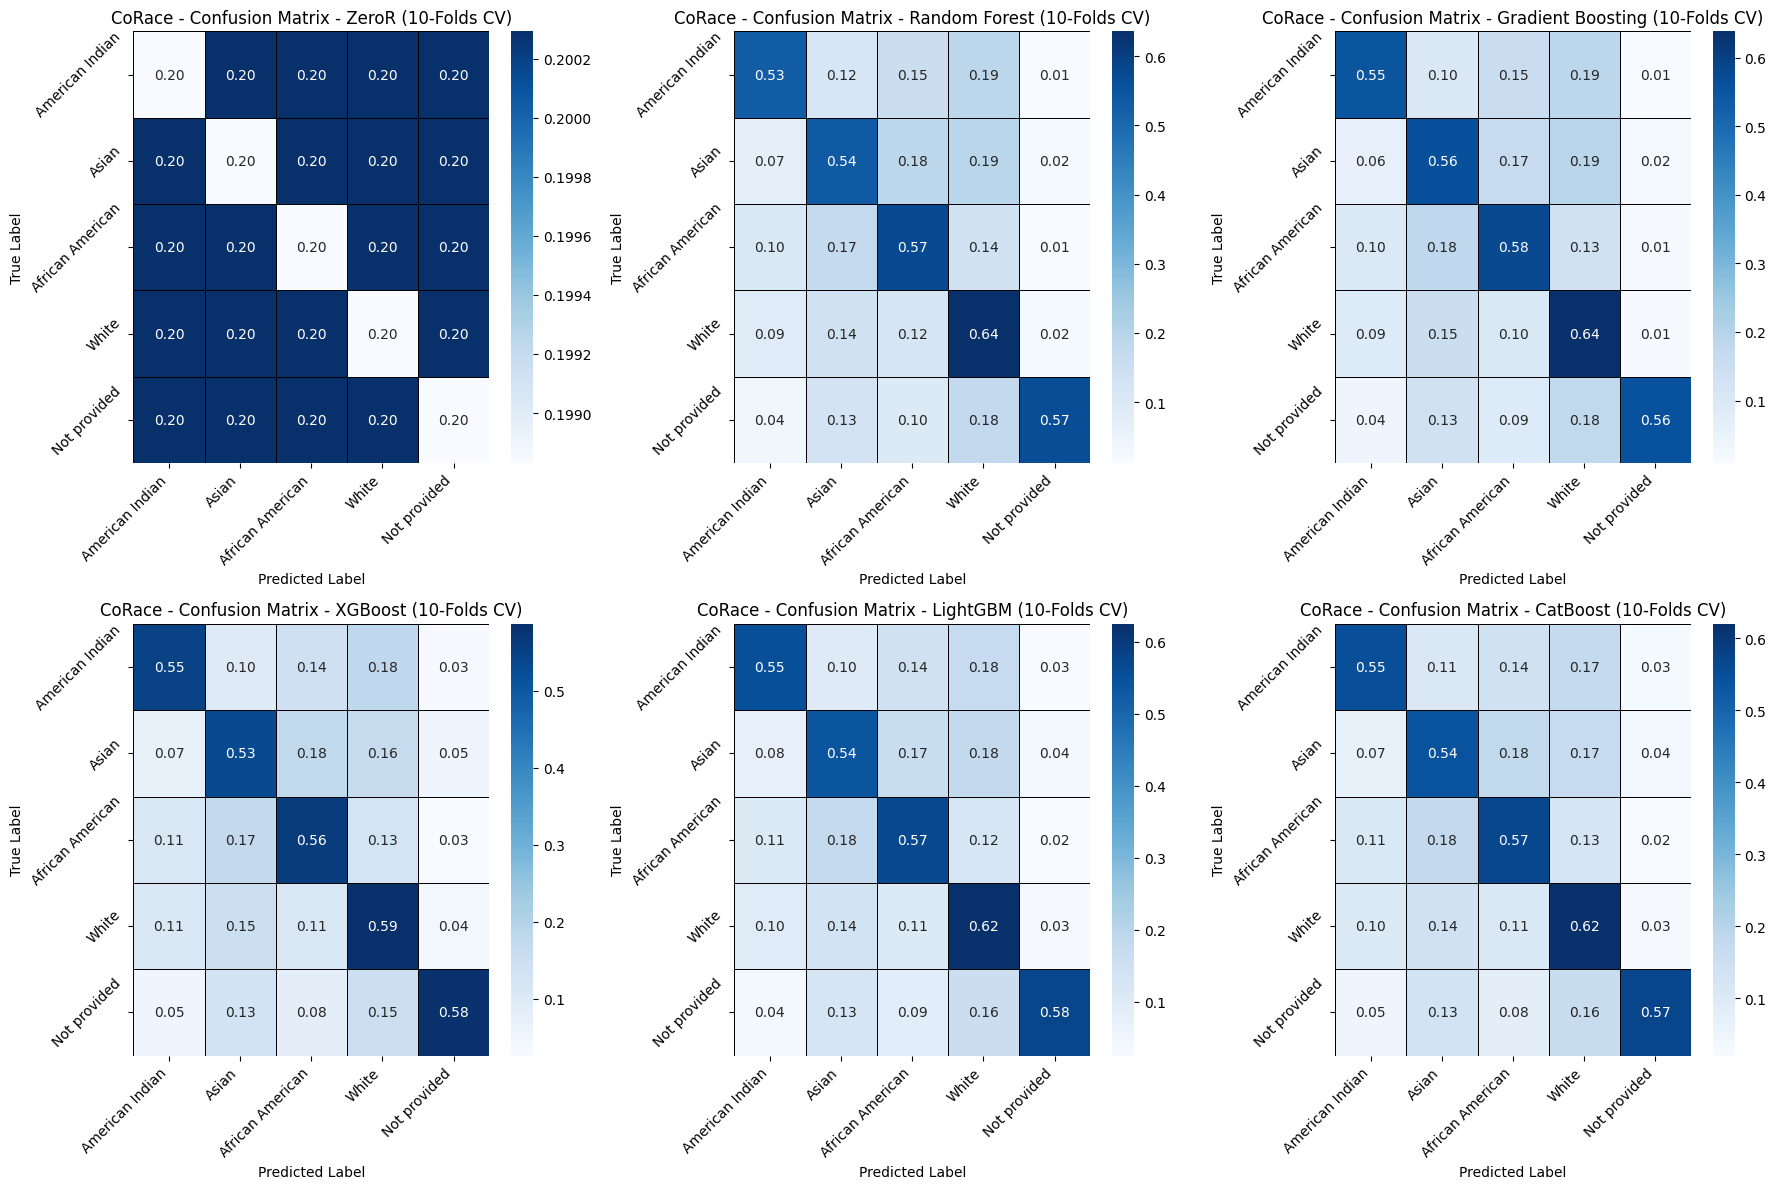

In [57]:
df = pd.read_csv("Samples/CoRace.csv")
X = df.drop(columns=["BoRace", "CoRace"])
y = df["CoRace"]
labels = ["American Indian", "Asian", "African American", "White", "Not provided"]

evaluate_models_on_split(df, "CoRace", models, labels, X, y)
evaluate_models_on_CV(df, "CoRace", models, labels, X, y)